In [1]:
# Import sys, then tell python where to find the nEXO-specific classes
import sys
sys.path.append('../../../modules')
# sys.path.append('/Users/sangiorgio1/SoftwareProjects/sensitivity/modules')

In [2]:
# Import useful libraries for analysis
import pandas as pd
from hist import Hist
import numpy as np
from matplotlib import pyplot as plt
import os
from pathlib import Path 
import hashlib
import itertools
import glob
import io
from contextlib import redirect_stdout, redirect_stderr

import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (10,8)

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

In [3]:
# Import the nEXO sensitivity classes
import nEXOFitWorkspace
import nEXOFitModel
import nEXOFitLikelihood

In [4]:
basedir = Path('/p/lustre2/nexouser/samuele/siteselection')
components_table_dir = Path('/p/lustre2/nexouser/samuele/multivarstudy/ComponentsTables')
outputdir = basedir / 'output'
plotdir = Path('plots')
os.makedirs(plotdir, exist_ok=True)

In [5]:
def load_fit_results(tag, s = None):
    h5_files = glob.glob(f'{outputdir}/*{tag}*.h5')
    if h5_files:
        print(f'Loading data for tag {tag}')
        if s: print(s)
        df_list = [pd.read_hdf(outputdir/Path(filename)) for filename in h5_files]
        df_tmp = pd.concat(df_list, ignore_index=True)
        print(f'---> Loaded {len(df_tmp)} toy datasets')
        return df_tmp
    return None

In [81]:
def get_expected_counts(mean_xe137_spec_activ):

    # Note that I use ComponentsTable and Config file that define a much finer binning
    config = '/g/g92/samuele/nEXO/sensitivity/work/SensitivityPaper2020_scripts/' \
             'SiteSelectionStudy/Sensitivity2020_Optimized_DNN_Standoff_Binning_version1_fineBinning_Xe137.yaml'
    input_table = components_table_dir / f'ComponentsTable_D-024_DNN_factor=0.0_ERes=0.008.h5'    

    if not input_table.is_file(): 
        print(f"file not exists: {input_table}")
        return

    workspace = nEXOFitWorkspace.nEXOFitWorkspace(config)
    workspace.LoadComponentsTableFromFile(input_table)

    for index, row in workspace.df_components.iterrows():
    # Scale the gamma ray background components, except radon
        # isotopes_to_leave_alone = ['Ar42', 'Xe137', 'bb2n', 'bb0n', 'B8nu', 'Rn222', ]  # just for bookkeeping
        # isotopes_to_scale = ['K40', 'Co60', 'Al26', 'Th232', 'U238', 'Cs137']
        # # The format is <isotope>_<part>, e.g. "Th232_HVCables"
        # if row['PDFName'].split('_')[0] in isotopes_to_scale:
        #     print(f'Scaling {row["PDFName"]}...')
        #     workspace.df_components.loc[index, 'SpecActiv'] = bkg_scale_factor * row['SpecActiv']
        #     workspace.df_components.loc[index, 'SpecActivErr'] = bkg_scale_factor * row['SpecActivErr']

        # Scale the Xe137 to the mean of the specified config distribution if present.
        # This is needed so the initial guesses are properly set
        # if ('Xe137' in row['PDFName']) and workspace.Xe137Sample:
        workspace.Xe137Sample = None
        if ('Xe137' in row['PDFName']):
            print(f'Setting {row["PDFName"]}...')
            workspace.df_components.loc[index, 'SpecActiv'] = mean_xe137_spec_activ
            workspace.df_components.loc[index, 'SpecActivErr'] = mean_xe137_spec_activ

    workspace.CreateGroupedPDFs()

    # Define the ROI within the workspace
    # Note that the ROI energy depends on the resolution since it's +/- FWHM/2
    # The DNN cut is set at the value for 85% signal efficiency
    fwhm = 2457 * 0.008 * 2.35
    roi_dict = {'DNN': [0.83, 1.],   # see values in the multivariation study tech note
                'Energy (keV)': [2457. - fwhm/2., 2457. + fwhm/2.],
                'Standoff (mm)': [104.5, 650.]}
    # roi_dict = {'DNN': [0.85, 1.],
    #         'Energy (keV)': [2434., 2480.],
    #         'Standoff (mm)': [104.5, 650.]}
    workspace.DefineROI(roi_dict)
#         print(workspace.df_components.loc[0])

    # Create the likelihood object
    likelihood = nEXOFitLikelihood.nEXOFitLikelihood()
    likelihood.AddPDFDataframeToModel(workspace.df_group_pdfs, workspace.histogram_axis_names)

    initial_guess = likelihood.GetVariableValues()

    # Scale the Rn222 component according to the input value
    # rn222_idx = likelihood.model.GetVariableIndexByName('Rn222')
    # initial_guess[rn222_idx] *= rn222_scale_factor

    # Update the model in the likelihood object
    likelihood.model.UpdateVariables(initial_guess)
    likelihood.model.GenerateModelDistribution()

    # Print out the number of events in the ROI
    print(workspace.GetROIBinIndices())
    total_bkg_in_roi = likelihood.model.GetIntegralInBinRange(workspace.GetROIBinIndices())
    output_str = f'TotalROIBkg: {total_bkg_in_roi} cts/10 y\n'
    output_str += f'Mean Xe137 Specific Activity: {workspace.mean_xe137_spec_activ:.4g} mBq/kg\n'

    for component in likelihood.model.variable_list:
        if 'Shape' in component['Name']:
            continue
        num_counts_in_roi = likelihood.model.GetComponentIntegralInBinRange(
            component['Name'], workspace.GetROIBinIndices())
        # df.at[tag, component['Name']] = num_counts_in_roi
        output_str += f'{component["Name"] + ":":<20}\t'
        output_str += f'{num_counts_in_roi:>10.4}\t'
        output_str += f'{int(1000 * num_counts_in_roi / total_bkg_in_roi) / 10.:>10.4}%\n'
    return output_str

In [65]:
# available tags: SURF_Eff80, LNGS_80, LNGS_RV, SNOLAB, WIPP_Eff80
res = load_fit_results("WIPP_Eff80")

Loading data for tag WIPP_Eff80
---> Loaded 4450 toy datasets


In [66]:
res.head()

,num_signal,lambda,fixed_fit_converged,fixed_fit_acc_covar,90CL_crossing,num_iterations,best_fit_converged,best_fit_covar,best_fit_iterations,best_fit_parameters,best_fit_errors,best_fit_nll,fixed_fit_parameters,fixed_fit_errors,input_parameters
0,"[1e-06, 1.4000009999999998, 2.800001, 4.200000...","[0.00013421635842458812, 0.001158823907788431,...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...",-1.0,"[2.0, 1.0, 4.0, 4.0, 2.0, 4.0, 1.0, 3.0, 2.0, ...",True,True,4,"{'Num_Far': 5661.182549372287, 'Num_Vessel_U23...","{1621.6603318685534: 1621.6603318685534, 13507...",-2.454463,"{'Num_Far': 5663.002671299364, 'Num_Vessel_U23...","{2963.91511364694: 2963.91511364694, 13542.199...","[5721.079378041755, 971.1196695977994, 1765.65..."
1,"[1e-06, 1.4000009999999998, 2.800001, 4.200000...","[-2.42098467708729e-05, 0.002438404318969134, ...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...",-1.0,"[1.0, 1.0, 1.0, 2.0, 4.0, 1.0, 1.0, 1.0, 2.0, ...",True,True,2,"{'Num_Far': 7361.2139128924855, 'Num_Vessel_U2...","{1269.3999561035494: 1269.3999561035494, 13656...",-4.446092,"{'Num_Far': 7361.215435530153, 'Num_Vessel_U23...","{1218.1052186800393: 1218.1052186800393, 12428...","[5064.378813663737, 3805.1081216569723, 630.23..."
2,"[1e-06, 1.4000009999999998, 2.800001, 4.200000...","[-9.373347953811617e-06, 0.0012003447433386327...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...",-1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",True,True,1,"{'Num_Far': 4369.83025337293, 'Num_Vessel_U238...","{1592.7989292356779: 1592.7989292356779, 17881...",-10.089142,"{'Num_Far': 4369.344018709496, 'Num_Vessel_U23...","{1309.0967281734736: 1309.0967281734736, 15983...","[5188.044644098526, 958.0152393274909, 797.655..."
3,"[1e-06, 1.4000009999999998, 2.800001, 4.200000...","[3.102205545424397e-05, 0.0005420973398937434,...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...",-1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",True,True,4,"{'Num_Far': 6821.032215943709, 'Num_Vessel_U23...","{5234.265052521972: 5234.265052521972, 14347.6...",-6.053000,"{'Num_Far': 6822.348420526624, 'Num_Vessel_U23...","{1009.7608554908265: 1009.7608554908265, 10499...","[5000.363856120175, 1429.288313241055, 228.190..."
4,"[1e-06, 1.4000009999999998, 2.800001, 4.200000...","[-5.936265796435691e-05, 0.001254267416474164,...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...",-1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",True,True,1,"{'Num_Far': 4557.8397300246115, 'Num_Vessel_U2...","{795.3990199984682: 795.3990199984682, 17781.0...",-10.426536,"{'Num_Far': 4561.086377787781, 'Num_Vessel_U23...","{1162.791773738406: 1162.791773738406, 17438.7...","[5746.507643349404, 1572.7400184138064, 278.44..."


In [98]:
mean_unvetoed_xe137 = 90.24  # in 10 y
mean_xe137_spec_activity = mean_unvetoed_xe137/4896/10.*1000/(365.*24*3600)
print(f'Xe137 scaling factor: {mean_xe137_spec_activity/2.684796228e-8:.1f}')
with redirect_stdout(io.StringIO()):    # capture output so it won't pollute the terminal
    with redirect_stderr(io.StringIO()):
        output_str = get_expected_counts(mean_xe137_spec_activity)

# output_str = get_expected_counts()
print("\n".join([output_str.split('\n')[i] for i in [0,1,12]]))

Xe137 scaling factor: 2.2
TotalROIBkg: 5.714516110988376 cts/10 y
Mean Xe137 Specific Activity: 3.724e-07 mBq/kg
Num_Xe137_and_Ar42: 	    0.3403	       5.9%


In [68]:
def get_good_fit_mask(df_fit):
    good_fit_mask = []
    for index,row in df_fit.iterrows():
        if np.sum(row['fixed_fit_acc_covar']) < len(row['fixed_fit_acc_covar'])-2 \
            or not row['best_fit_covar'] \
            or row['90CL_crossing'] < 0.01\
            or row['best_fit_nll'] > 0.:
            good_fit_mask.append(False)
        else:
            good_fit_mask.append(True)
    return good_fit_mask

In [69]:
good_fit_mask = get_good_fit_mask(res)
convergence_f = np.sum(good_fit_mask)/len(res)
print(f'Convergence fraction: {convergence_f:3.3}')

Convergence fraction: 0.0211


42177319.768


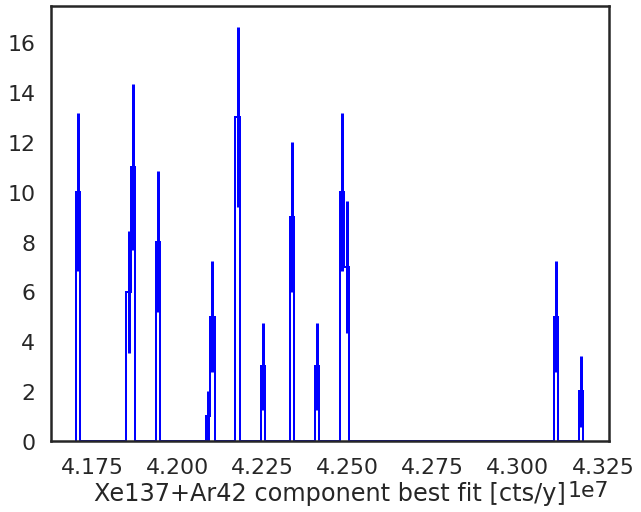

In [70]:
Xe137_best_fits = [r['Num_Xe137_and_Ar42'] for r in res['best_fit_parameters'].loc[good_fit_mask]]
Xe137_best_fits = np.array(Xe137_best_fits)/10.
fig, ax = plt.subplots()
h = Hist.new.Regular(121, min(Xe137_best_fits), max(Xe137_best_fits), name="signal_counts").Double()
h.fill(Xe137_best_fits)
median = np.median(Xe137_best_fits)
print(f'{median:.3f}')

h.plot1d(ax=ax,)

# plt.legend()
plt.xlabel('Xe137+Ar42 component best fit [cts/y]')
# plt.yscale('log')
plt.show()

42177458.347


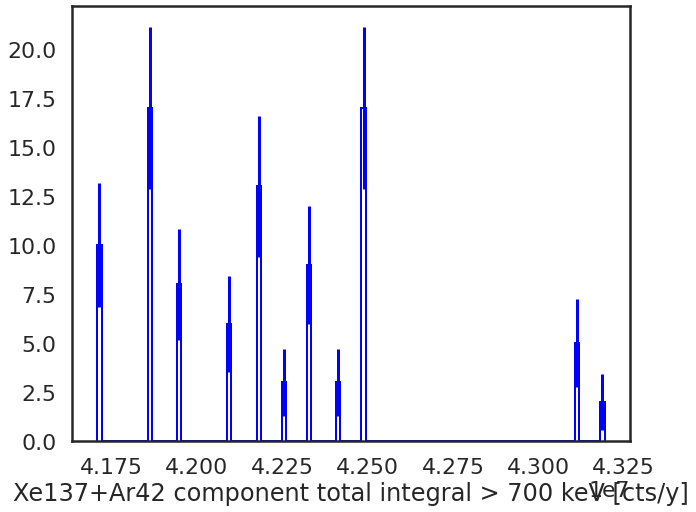

In [71]:
Xe137_input = [r[-1] for r in res['input_parameters'].loc[good_fit_mask]]
Xe137_input = np.array(Xe137_input)/10.
# print(Xe137_input, min(Xe137_input), max(Xe137_input)  )
fig, ax = plt.subplots()
h = Hist.new.Regular(121, min(Xe137_input), max(Xe137_input), name="signal_counts").Double()
h.fill(Xe137_input)
median = np.median(Xe137_input)
print(f'{median:.3f}')

h.plot1d(ax=ax,)

# plt.legend()
plt.xlabel('Xe137+Ar42 component total integral > 700 keV [cts/y]')
# plt.yscale('log')
plt.show()

In [72]:
def calc_atoms_136(enrichment_fraction=0.9):
    """ Number of Xe136 atoms in nEXO fiducial volume """
    mmass134 = 0.133905395  # kg/mol 134
    mmass136 = 0.135907219  # kg/mol 136
    at_frac = enrichment_fraction           # atomic fraction 136 / (136 + 134)
    avog_num = 6.022141E23  # Avogadro's number
    fid_mass = 3281         # mass of fiducial volume [kg]

    atoms136 = (fid_mass * avog_num * at_frac) / ((mmass136 * at_frac) + ((1 - at_frac) * mmass134))

    return atoms136


def ComputeHalflifeFromNumCounts(counts, enrichment_fraction=0.9, lifetime=10):
    """Calculate the sensitivity of nEXO in terms of half-life (years)"""
    atoms136 = calc_atoms_136(enrichment_fraction)
    eff = 0.9598  # hit efficiency
    sensitivity = eff * atoms136 * lifetime * np.log(2) / counts
    return sensitivity


def ComputeCountsFromHalflife(sensitivity, enrichment_fraction=0.9, lifetime=10):
    """Calculate the sensitivity of nEXO in terms of half-life (years)"""
    atoms136 = calc_atoms_136(enrichment_fraction)
    eff = 0.9598  # hit efficiency
    counts = eff * atoms136 * lifetime * np.log(2) / sensitivity
    return counts
    

# def ComputeHalflifeFromNumCounts( counts, enrichment_fraction=0.9 ):
#     '''Returns the half life which would give (on average) the input number of signal counts'''
    
#     N_A = 6.02e23 # atoms/mol
#     FidMass = 3281 # kg
#     AtomicMass = 135.8 # g/mol
#     SigEfficiency = 0.96
#     Livetime = 10 # years
#     return FidMass*1.e3 / AtomicMass * N_A * enrichment_fraction * Livetime * \
#             SigEfficiency * np.log(2) / counts


Median [cts]	Sensitivity [y]
36.809	2.368e+27


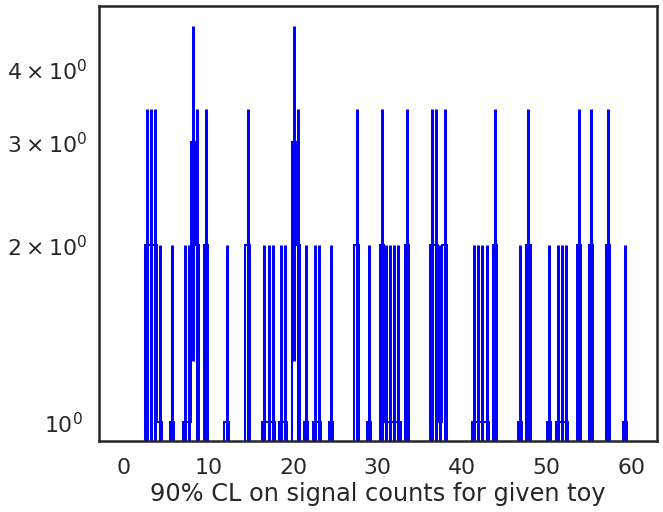

In [73]:
print('Median [cts]\tSensitivity [y]')
fig, ax = plt.subplots()
h = Hist.new.Regular(121, 0, 60, name="signal_counts").Double()
values = res['90CL_crossing'].loc[good_fit_mask]
h.fill(values)
median = np.median(values)
sens = ComputeHalflifeFromNumCounts(median)
print(f'{median:.3f}\t{sens:.3e}')
#     print(f'Results for tag {tag}')
#     print(f'   Median 90%CL on signal counts: {median:.3f}')
#     print(f'   Sensitivity: {df.at[tag, "sens"]:.3e} years')

h.plot1d(ax=ax,)

# plt.legend()
plt.xlabel('90% CL on signal counts for given toy')
plt.yscale('log')